# Google COVID-19 mobility data process v1

In this notebook I combine the `place_id` identifier used in the Google Mobility Reports with the google maps api in order to derive lat long corodinates for each of the places listed.

In [1]:
import pandas as pd
import requests
import simplejson as json

---

## Great Britain

First import the Great Britain file for 2020 as a test run, before working on the much larger file containing data for the whole world.

In [2]:
gbDf = pd.read_csv("./source-data/Region_Mobility_Report_CSVs/2020_GB_Region_Mobility_Report.csv")

Check that the `place_id` column is present.

In [3]:
gbDf.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-15,-12.0,-7.0,-35.0,-12.0,-4.0,2.0
1,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-16,-7.0,-6.0,-28.0,-7.0,-3.0,1.0
2,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-17,10.0,1.0,24.0,-2.0,-14.0,2.0
3,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-18,7.0,-1.0,20.0,-3.0,-14.0,2.0
4,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-19,6.0,-2.0,8.0,-4.0,-14.0,3.0


Extract just the `place_id` column into a new data frame and keep only the unique values.

In [4]:
placeIdDf = gbDf[["place_id"]]

In [5]:
len(placeIdDf)

133382

In [6]:
uniquePlaceIdDf = placeIdDf.drop_duplicates()

In [7]:
len(uniquePlaceIdDf)

419

In [8]:
uniquePlaceIdDf.head()

,place_id
0,ChIJqZHHQhE7WgIReiWIMkOg-MQ
321,ChIJs6qVe2kRhEgRkLBCBhpoDAM
642,ChIJ1deuZ9h_g0gRB-LNSfT9NVA
963,ChIJG0UKe3kqhEgRsxEd27rxlSg
1278,ChIJ-QsErn2rYUgR-WEb8k5G8Bw


---

## Access the google maps api

Construct a function to loop through the `placeIdDf` data frame and call the google maps api for each row, returning the lat and long coordinates as applying these as columns to the data frame.

In [7]:
with open('./secrets/googleapikey.txt', 'r') as f:
    key = f.read()

In [36]:
def get_lat_long(place_id):
    try:
        API_KEY = key.rstrip("\n")
        url = "https://maps.googleapis.com/maps/api/place/details/json?place_id=" + str(place_id) + "&key=" + str(API_KEY) + "&fields=geometry"
        
        response = (requests.get(url).text)
        response_json = json.loads(response)
        
        if "result" in response_json:
            result = response_json["result"]
            if "geometry" in result:
                geometry = result["geometry"]
                if "location" in geometry:
                    location = geometry["location"]
                    return location["lat"], location["lng"]
                else:
                    return None, None
            else:
                return None, None
        else:
            return None, None
    
    except Exception as e:
        raise e

In [93]:
uniquePlaceIdDf.loc[:, "lat"], uniquePlaceIdDf.loc[:, "lng"] = zip(*uniquePlaceIdDf['place_id'].map(get_lat_long))

In [94]:
uniquePlaceIdDf.head()

,place_id,lat,lng
0,ChIJqZHHQhE7WgIReiWIMkOg-MQ,55.378051,-3.435973
321,ChIJs6qVe2kRhEgRkLBCBhpoDAM,57.159996,-2.114243
642,ChIJ1deuZ9h_g0gRB-LNSfT9NVA,57.286872,-2.381568
963,ChIJG0UKe3kqhEgRsxEd27rxlSg,56.697954,-2.912406
1278,ChIJ-QsErn2rYUgR-WEb8k5G8Bw,54.672224,-6.170397


We'll now print this dataframe to a csv for later use

In [95]:
uniquePlaceIdDf.to_csv("./output-data/gb-placeid-lat-lng.csv", index=False)

---

## Merge lat long coordinates with original GB data

In [6]:
gbPlaceidLatLngDf = pd.read_csv("./output-data/gb-placeid-lat-lng.csv")

In [264]:
gbMergeDf = pd.merge(gbDf, gbPlaceidLatLngDf, on='place_id', how='outer')

In [265]:
gbMergeDf.tail()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,lat,lng
133377,GB,United Kingdom,York,NaN,NaN,GB-YOR,NaN,ChIJh-IigLwxeUgRAKFv7Z75DAM,2020-12-27,-51.0,-26.0,-32.0,-38.0,-20.0,9.0,53.962288,-1.081827
133378,GB,United Kingdom,York,NaN,NaN,GB-YOR,NaN,ChIJh-IigLwxeUgRAKFv7Z75DAM,2020-12-28,-25.0,-16.0,21.0,-35.0,-73.0,23.0,53.962288,-1.081827
133379,GB,United Kingdom,York,NaN,NaN,GB-YOR,NaN,ChIJh-IigLwxeUgRAKFv7Z75DAM,2020-12-29,-22.0,-6.0,14.0,-37.0,-64.0,21.0,53.962288,-1.081827
133380,GB,United Kingdom,York,NaN,NaN,GB-YOR,NaN,ChIJh-IigLwxeUgRAKFv7Z75DAM,2020-12-30,-22.0,-1.0,7.0,-37.0,-62.0,20.0,53.962288,-1.081827
133381,GB,United Kingdom,York,NaN,NaN,GB-YOR,NaN,ChIJh-IigLwxeUgRAKFv7Z75DAM,2020-12-31,-46.0,3.0,7.0,-57.0,-67.0,23.0,53.962288,-1.081827


Now we'll save this dataframe to a csv for some test visualisation.

In [9]:
gbMergeDf.to_csv("./output-data/gb-merge-lat-long.csv", index=False)

---

## Calculate a moving average

I now want to calculate a moving average, with a window size of seven days to smooth out the data and make any trends easier to spot.

In [3]:
gbMergeDf = pd.read_csv("./output-data/gb-merge-lat-long.csv")

I'll quickly visualise the data for a random region, just so we can see how the rolling average is applied.

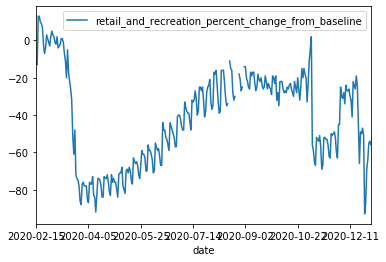

In [5]:
gbMergeDf[gbMergeDf["place_id"] == "ChIJ-2lzwCCLdkgRIOfCu6gcDgQ"].plot.line(x="date", y=[
    "retail_and_recreation_percent_change_from_baseline",
])

In [8]:
def add_rolling_average(df):
    df.loc[:, "retail-average"] = df["retail_and_recreation_percent_change_from_baseline"].rolling(window=7, center=True).mean()
    df.loc[:, "grocery-average"] = df["grocery_and_pharmacy_percent_change_from_baseline"].rolling(window=7, center=True).mean()
    df.loc[:, "parks-average"] = df["parks_percent_change_from_baseline"].rolling(window=7, center=True).mean()
    df.loc[:, "transit-average"] = df["transit_stations_percent_change_from_baseline"].rolling(window=7, center=True).mean()
    df.loc[:, "workplace-average"] = df["workplaces_percent_change_from_baseline"].rolling(window=7, center=True).mean()
    df.loc[:, "residential-average"] = df["residential_percent_change_from_baseline"].rolling(window=7, center=True).mean()
    
    return df

In [7]:
gbAverageDf = gbMergeDf.groupby("place_id").apply(add_rolling_average)

We should now have now `average` columns added for each location. The first three values will be `NaN` as we're counting a seven day average starting from day 4

In [8]:
gbAverageDf.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,...,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,lat,lng,retail-average,grocery-average,parks-average,transit-average,workplace-average,residential-average
0,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-15,-12.0,...,-4.0,2.0,55.378051,-3.435973,NaN,NaN,NaN,NaN,NaN,NaN
1,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-16,-7.0,...,-3.0,1.0,55.378051,-3.435973,NaN,NaN,NaN,NaN,NaN,NaN
2,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-17,10.0,...,-14.0,2.0,55.378051,-3.435973,NaN,NaN,NaN,NaN,NaN,NaN
3,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-18,7.0,...,-14.0,2.0,55.378051,-3.435973,2.000000,-2.571429,0.428571,-5.142857,-11.142857,2.285714
4,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-19,6.0,...,-14.0,3.0,55.378051,-3.435973,3.142857,-1.857143,4.428571,-3.714286,-10.857143,2.142857


Now we can see that the line is much smoother.

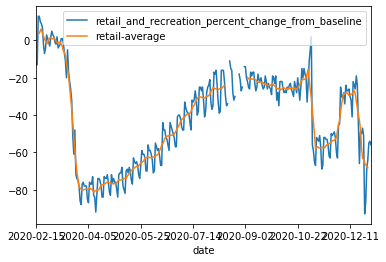

In [9]:
gbAverageDf[gbAverageDf["place_id"] == "ChIJ-2lzwCCLdkgRIOfCu6gcDgQ"].plot.line(x="date", y=[
    "retail_and_recreation_percent_change_from_baseline",
    "retail-average"
])

In [10]:
gbAverageDf.to_csv("./output-data/gb-average.csv", index=False)

---

## Split the data into regions and sub regions

The data contains different density of locations. I'll split these up into separate files to visualise ie London and the UK as a whole.

- `country_region_code` and `country_region` = All GB and United Kingdom in this file.
- `sub_region_1` = Cities and counties
- `sub_region_1` = Districts and boroughs

In [11]:
gbWholeDf = pd.read_csv("./output-data/gb-average.csv")

In [17]:
countryRegionCodeCount = len(gbWholeDf["country_region_code"].drop_duplicates())
countryRegionCount = len(gbWholeDf["country_region"].drop_duplicates())

f'There are {countryRegionCodeCount} unique "country_region_code" and {countryRegionCount} unique "country_region"'

'There are 1 unique "country_region_code" and 1 unique "country_region"'

In [20]:
subRegion1Count = len(gbWholeDf["sub_region_1"].drop_duplicates())

f'There are {subRegion1Count} unique "sub_region_1" values'

'There are 152 unique "sub_region_1" values'

In [21]:
subRegion2Count = len(gbWholeDf["sub_region_2"].drop_duplicates())

f'There are {subRegion2Count} unique "sub_region_2" values'

'There are 268 unique "sub_region_2" values'

Create a new data frame containing just the rows that pertain to a Sub Region 1 area. 

These will have a value in the `sub_region_1` column but not in the `sub_region_2` column.

In [34]:
gbSubRegion1Df = gbWholeDf[gbWholeDf["sub_region_1"].notnull() & gbWholeDf["sub_region_2"].isnull()]

In [39]:
gbSubRegion1Df["sub_region_1"].drop_duplicates().to_list()[0:10]

['Aberdeen City',
 'Aberdeenshire',
 'Angus Council',
 'Antrim and Newtownabbey',
 'Ards and North Down',
 'Argyll and Bute Council',
 'Armagh City, Banbridge and Craigavon',
 'Bath and North East Somerset',
 'Bedford',
 'Belfast']

Create a new data frame containing just rowns that pertain to boroughs of Greater London.

In [47]:
gbLondonDf = gbWholeDf[(gbWholeDf["sub_region_1"] == "Greater London") & gbWholeDf["sub_region_2"].notnull()]

In [48]:
gbLondonDf["sub_region_2"].drop_duplicates().to_list()[0:10]

['City of London',
 'City of Westminster',
 'London Borough of Barking and Dagenham',
 'London Borough of Barnet',
 'London Borough of Bexley',
 'London Borough of Brent',
 'London Borough of Bromley',
 'London Borough of Camden',
 'London Borough of Croydon',
 'London Borough of Ealing']

I'll save both of these data frames as csvs for later use.

In [49]:
gbSubRegion1Df.to_csv("./output-data/gb-sub-region-1.csv", index=False)

In [50]:
gbLondonDf.to_csv("./output-data/gb-londono.csv", index=False)

---

## Reduce the size of the CSV file

The GB file alone is 19mb - but there are lots of repeated fields. I'll try to reformat the data so that it can be saved to in a smaller file.

I'll use a function to reformat a dataframe by grouping on the `place_id` field and the collecting the data for each location, which can be stored as a python dictionary and each appending to a list. 

This list can then be exported as json for use in the visualisation.

In [46]:
def create_list_for_json(df):
    outputList = []
    listOfPlaceIds = df["place_id"].drop_duplicates().to_list()
    groupByPlaceId = df.groupby("place_id")
    
    for place_id in listOfPlaceIds:
        thisDf = groupByPlaceId.get_group(place_id)
        myDict = {}
        myDict['place_id'] = place_id
        myDict['country_region'] = thisDf.iloc[0]["country_region"]
        myDict['sub_region_1'] = thisDf.iloc[0]["sub_region_1"]
        myDict['sub_region_2'] = thisDf.iloc[0]["sub_region_2"]
        myDict['lng'] = thisDf.iloc[0]["lng"]
        myDict["lat"] =  thisDf.iloc[0]["lat"]
        
        myDict["date"] =  thisDf["date"].to_list()

        # retail_and_recreation_percent_change_from_baseline
        myDict["retail"] =  thisDf["retail-average"].to_list()

        # grocery_and_pharmacy_percent_change_from_baseline
        myDict["grocery"] =  thisDf["grocery-average"].to_list()

        # parks_percent_change_from_baseline
        myDict["parks"] =  thisDf["parks-average"].to_list()

        # transit_stations_percent_change_from_baseline
        myDict["transit"] =  thisDf["transit-average"].to_list()

        # workplaces_percent_change_from_baseline
        myDict["workplaces"] =  thisDf["workplace-average"].to_list()

        # residential_percent_change_from_baseline
        myDict["residential"] =  thisDf["residential-average"].to_list()

        outputList.append(myDict)
        
    return outputList

In [92]:
gbSubRegion1List = create_list_for_json(gbSubRegion1Df)

In [91]:
gbLondonList = create_list_for_json(gbLondonDf)

I will now export these lists as json for visualisation.

Using `ignore_nan=True` with the `simplejson` package to output `NaN` values as `null`.

In [94]:
with open("output-data/data-gb-sub-region-1.json", "w") as outfile: 
    json.dump(gbSubRegion1List, outfile, ignore_nan=True)

In [95]:
with open("output-data/data-gb-london.json", "w") as outfile: 
    json.dump(gbLondonList, outfile, ignore_nan=True)

---

## The Whole World

Now I want to repeat this process with the data file for the whole world.

In [2]:
worldDf = pd.read_csv("./output-data/world-country-region.csv")

In [3]:
worldDf.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


Get a list of unique `place_id` values.

In [6]:
uniqueWorldPlaceIdDf = worldDf[["place_id"]].drop_duplicates()

Access the Google Maps Api to get lat long coordinates for each place.

In [10]:
uniqueWorldPlaceIdDf.loc[:, "lat"], uniqueWorldPlaceIdDf.loc[:, "lng"] = zip(*uniqueWorldPlaceIdDf['place_id'].map(get_lat_long))

In [11]:
uniqueWorldPlaceIdDf.head()

,place_id,lat,lng
0,ChIJvRKrsd9IXj4RpwoIwFYv0zM,23.424076,53.847818
448,ChIJbQL_-LZu0TgReNqWvg1GtfM,33.939110,67.709953
851,ChIJwdG4bbluDYwRlHmL4Yg3aic,17.060816,-61.796428
1293,ChIJJ4utyk7yURoRPU5KDZ0oClk,-11.202692,17.873887
1741,ChIJZ8b99fXKvJURqA_wKpl3Lz0,-38.416097,-63.616672


Save this file as a CSV for later use.

In [12]:
uniqueWorldPlaceIdDf.to_csv("./output-data/world-placeid-lat-lng.csv", index=False)

Merge the lat long coordinates with the orignial world data.

In [13]:
worldMergeDf = pd.merge(worldDf, uniqueWorldPlaceIdDf, on='place_id', how='outer')

In [14]:
worldMergeDf.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,lat,lng
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0,23.424076,53.847818
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0,23.424076,53.847818
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0,23.424076,53.847818
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0,23.424076,53.847818
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0,23.424076,53.847818


Calculate the rolling average for each location.

In [16]:
worldAverageDf = worldMergeDf.groupby("place_id").apply(add_rolling_average)

Rearrange the data into a list of dictionaries.

In [19]:
worldList = create_list_for_json(worldAverageDf)

Save the list out as json.

In [21]:
with open("output-data/data-world.json", "w") as outfile: 
    json.dump(worldList, outfile, ignore_nan=True)

---

## World sub_region_1 

For a more granular world map.

In [2]:
worldSubRegion1Df = pd.read_csv("./output-data/world-sub-region-1.csv")

In [3]:
worldSubRegion1Df.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2020-02-15,1.0,6.0,-2.0,-1.0,2.0,1.0
1,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2020-02-16,-2.0,5.0,2.0,-2.0,2.0,1.0
2,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2020-02-17,-3.0,2.0,4.0,-3.0,2.0,1.0
3,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2020-02-18,-3.0,2.0,1.0,-2.0,2.0,1.0
4,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2020-02-19,-3.0,1.0,0.0,-1.0,2.0,1.0


In [5]:
uniqueSubRegion1PlaceIdDf = worldSubRegion1Df[["place_id"]].drop_duplicates()

In [21]:
len(uniqueSubRegion1PlaceIdDf)

1871

In [38]:
uniqueSubRegion1PlaceIdDf.loc[:, "lat"], uniqueSubRegion1PlaceIdDf.loc[:, "lng"] = zip(*uniqueSubRegion1PlaceIdDf['place_id'].map(get_lat_long))

In [39]:
uniqueSubRegion1PlaceIdDf.head()

,place_id,lat,lng
0,ChIJGczaTT5mXj4RBNmakTvGr4s,23.4677,53.7369
448,ChIJHwyp6rZXXz4RerixWbtcrRE,25.4052,55.5136
896,ChIJRcbZaklDXz4R6SkAK7_QznQ,24.9822,55.4029
1344,ChIJX7kokD0y9D4RvDyz2xuxwaY,25.4111,56.2482
1792,ChIJpwnSTA5x9j4RD-KEpgxnnrk,25.6741,55.9804


In [40]:
uniqueSubRegion1PlaceIdDf.to_csv("./output-data/world-sub-region-1-placeid-lat-lng.csv", index=False)

Re-load the CSV

In [4]:
uniqueSubRegion1PlaceIdDf = pd.read_csv("./output-data/world-sub-region-1-placeid-lat-lng.csv")

In [5]:
worldSubRegion1MergeDf = pd.merge(worldSubRegion1Df, uniqueSubRegion1PlaceIdDf, on='place_id', how='outer')

In [6]:
worldSubRegion1MergeDf.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,lat,lng
0,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2020-02-15,1.0,6.0,-2.0,-1.0,2.0,1.0,23.467723,53.736915
1,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2020-02-16,-2.0,5.0,2.0,-2.0,2.0,1.0,23.467723,53.736915
2,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2020-02-17,-3.0,2.0,4.0,-3.0,2.0,1.0,23.467723,53.736915
3,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2020-02-18,-3.0,2.0,1.0,-2.0,2.0,1.0,23.467723,53.736915
4,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2020-02-19,-3.0,1.0,0.0,-1.0,2.0,1.0,23.467723,53.736915


In [9]:
worldSubRegion1AverageDf = worldSubRegion1MergeDf.groupby("place_id").apply(add_rolling_average)

In [10]:
worldSubRegion1AverageDf.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,...,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,lat,lng,retail-average,grocery-average,parks-average,transit-average,workplace-average,residential-average
0,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2020-02-15,1.0,...,2.0,1.0,23.467723,53.736915,NaN,NaN,NaN,NaN,NaN,NaN
1,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2020-02-16,-2.0,...,2.0,1.0,23.467723,53.736915,NaN,NaN,NaN,NaN,NaN,NaN
2,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2020-02-17,-3.0,...,2.0,1.0,23.467723,53.736915,NaN,NaN,NaN,NaN,NaN,NaN
3,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2020-02-18,-3.0,...,2.0,1.0,23.467723,53.736915,-1.714286,3.285714,2.285714,-2.428571,1.428571,1.0
4,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2020-02-19,-3.0,...,2.0,1.0,23.467723,53.736915,-2.000000,3.000000,2.857143,-2.571429,1.571429,1.0


Now I'll reduce the number of decimal places in the averages - to keep the file size down.

In [13]:
worldSubRegion1AverageRoundedDf = worldSubRegion1AverageDf.round({
    'retail-average': 1, 
    'grocery-average': 1, 
    'parks-average': 1, 
    'transit-average': 1,
    'workplace-average': 1,
    'residential-average': 1
})

In [14]:
worldSubRegion1AverageRoundedDf.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,...,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,lat,lng,retail-average,grocery-average,parks-average,transit-average,workplace-average,residential-average
0,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2020-02-15,1.0,...,2.0,1.0,23.467723,53.736915,NaN,NaN,NaN,NaN,NaN,NaN
1,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2020-02-16,-2.0,...,2.0,1.0,23.467723,53.736915,NaN,NaN,NaN,NaN,NaN,NaN
2,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2020-02-17,-3.0,...,2.0,1.0,23.467723,53.736915,NaN,NaN,NaN,NaN,NaN,NaN
3,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2020-02-18,-3.0,...,2.0,1.0,23.467723,53.736915,-1.7,3.3,2.3,-2.4,1.4,1.0
4,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2020-02-19,-3.0,...,2.0,1.0,23.467723,53.736915,-2.0,3.0,2.9,-2.6,1.6,1.0


In [15]:
len(worldSubRegion1AverageRoundedDf["place_id"])

785978

There seem to be some `plae_id` values listed as NaN which is causing problems - I'll remove those rows.

In [16]:
worldSubRegion1AverageRoundedDfNotNaN = worldSubRegion1AverageRoundedDf[worldSubRegion1AverageRoundedDf["place_id"].notna()]

In [17]:
len(worldSubRegion1AverageRoundedDfNotNaN["place_id"])

785082

To make a list of all this data would result in a 70mb file - for now I'll just export the data for parks.

In [18]:
def create_list_for_json_just_parks(df):
    outputList = []
    listOfPlaceIds = df["place_id"].drop_duplicates().to_list()
    groupByPlaceId = df.groupby("place_id")
    
    for place_id in listOfPlaceIds:
        thisDf = groupByPlaceId.get_group(place_id)
        myDict = {}
        myDict['place_id'] = place_id
        myDict['country_region'] = thisDf.iloc[0]["country_region"]
        myDict['sub_region_1'] = thisDf.iloc[0]["sub_region_1"]
        myDict['lng'] = thisDf.iloc[0]["lng"]
        myDict["lat"] =  thisDf.iloc[0]["lat"]

        # parks_percent_change_from_baseline
        myDict["parks"] =  thisDf["parks-average"].to_list()

        outputList.append(myDict)
        
    return outputList

In [19]:
worldSubRegion1ParksList = create_list_for_json_just_parks(worldSubRegion1AverageRoundedDfNotNaN)

In [20]:
with open("output-data/data-world-sub-region-1-parks.json", "w") as outfile: 
    json.dump(worldSubRegion1ParksList, outfile, ignore_nan=True)